## Part II: Swatches

In [1]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.ndimage import generic_filter

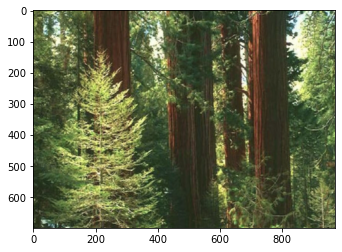

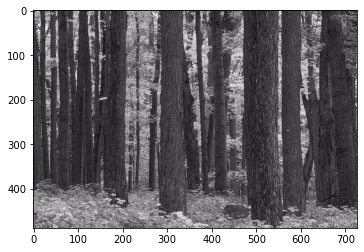

In [2]:
# reed and display the input source image and target image
swatch_image_1 = cv2.imread('input/swatch_color_1.jpg')  
swatch_image_2 = cv2.imread('input/swatch_gray_1.jpg')
plt.imshow(cv2.cvtColor(swatch_image_1, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(swatch_image_2, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# convert images color space: BGR -> LAB
swatch_source = cv2.cvtColor(swatch_image_1, cv2.COLOR_BGR2LAB).astype("float32")
swatch_target = cv2.cvtColor(swatch_image_2, cv2.COLOR_BGR2LAB).astype("float32")

In [4]:
# luminance remapping: L = (std_t / std_s) * (1 - mu_s) + mu_t
# source_l: luminance of source
# target_l: luminance of target
def luminiance_remap(source_l, target_l):
    s_std = np.std(source_l)
    t_std = np.std(target_l)
    s_mean = np.mean(source_l)
    t_mean = np.mean(target_l)
    remap = (source_l - s_mean)* (t_std / s_std) + t_mean
    return remap


# jittered sampling grid: approximate 200 color sample points
# source_img: source image (LAB)
# num: number of sample points need to be generated
def jitter_sampling(source_img, num):
    n = int(np.sqrt(num)) # n * n grid size
    sample = np.zeros([n,n,3])
    height, width, _ = source_img.shape 
    y = height // n # height interval
    x = width // n # width interval
    
    for i in range(0,n):
        for j in range(0,n):
            # (0, y-1), (y, 2y-1), (2y, 3y-1)..., ((n-1)y, ny-1)
            h_start = i*y
            h_end = (i+1)*y-1
            rand_h = random.randint(h_start, h_end)
            # (0, x-1), (x, 2x-1), (2x, 3x-1)..., ((n-1)x, nx-1)
            w_start = j*x
            w_end = (j+1)*x-1
            rand_w = random.randint(w_start, w_end)
            
            sample[i,j,:] = source_img[rand_h,rand_w,:] # store sample point
            
#     print(sample)
    return sample


# standard deviation of the luminance in the neighborhood range
# 5*5 size neighbourhood ok
def std_neighbourhood(image, num):
    # scipy.ndimage.generic_filter(input, function, size=None, footprint=None, output=None, mode='reflect', cval=0.0, origin=0, extra_arguments=(), extra_keywords=None)
    std = generic_filter(image, np.std, size = num)
    return std


# Weight value: 50% luminance and 50% standard deviation
# Based on weight value, find the best matching point and assign (A,B) to target image
def color_transfer(source,target,source_std,target_std):
    # seperate lab chanel
    l_s,a_s,b_s = cv2.split(source)
    l_t,a_t,b_t = cv2.split(target)
    height, width = l_t.shape
    ratio = 0.5
    
    for i in range(height):
        for j in range(width):
            w = ratio * np.abs(l_s - l_t[i,j]) + ratio * np.abs(source_std - target_std[i,j])
            pos = np.argwhere(w == np.min(w)) # minimum w, find the closest matching point
            i_t = pos[0,0]
            j_t = pos[0,1]
            a_t[i,j] = a_s[i_t, j_t]
            b_t[i,j] = b_s[i_t, j_t]
            
    result = cv2.merge([l_t,a_t,b_t])
    result = result.astype("uint8")
    return result

In [5]:
def crop_source(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        coords.append([x,y]) # record crop point position
        cv2.circle(swatch_image_1,(x,y),1,(255,255,255), 2) 
        cv2.imshow('source', swatch_image_1)
        # after choose two points, press any key to quit
        if len(coords)%2 == 0:
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            
def crop_target(event, x, y, flags, params): 
    if event == cv2.EVENT_LBUTTONDOWN:
        coords.append([x,y]) # record crop point position
        cv2.circle(swatch_image_2,(x,y),1,(255,255,255), 2) 
        cv2.imshow('target', swatch_image_2)
        # after choose two points, press any key to quit
        if len(coords)%2 == 0:
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [6]:
count = 2 # the number of swatches, user can change it
colored_swatches = []
swatch_pos = {}
for i in range(0, count):
    coords = [] # [[s_l_t_x, s_l_t_y], [s_r_b_x, s_r_b_y], [t_l_t_x, t_l_t_y], [t_r_b_x, t_r_b_y]]
    # Notice: first point should be left-top, second point should be right-bottom
    cv2.imshow('source',swatch_image_1)
    cv2.setMouseCallback('source', crop_source)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    cv2.imshow('target',swatch_image_2) 
    cv2.setMouseCallback('target', crop_target) 
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    
    source_swatch_seg = swatch_source[coords[0][1]:coords[1][1]+1,coords[0][0]:coords[1][0]+1,:]
    target_swatch_seg = swatch_target[coords[2][1]:coords[3][1]+1,coords[2][0]:coords[3][0]+1,:]
    swatch_pos[i] = coords
    
    source_swatch_seg[:,:,0] = luminiance_remap(source_swatch_seg[:,:,0],target_swatch_seg[:,:,0])
    
    sampled_source_swatch = jitter_sampling(source_swatch_seg,50)

    swatch_source_std = std_neighbourhood(sampled_source_swatch[:,:,0],5)
    swatch_target_std = std_neighbourhood(target_swatch_seg[:,:,0],5)

    swatch_transfered = color_transfer(sampled_source_swatch,target_swatch_seg,swatch_source_std,swatch_target_std)
    colored_swatches.append(swatch_transfered)
    

In [7]:
# for i in range(len(colored_swatches)):
#     plt.imshow(cv2.cvtColor(colored_swatches[i], cv2.COLOR_LAB2RGB))
#     plt.show()

In [8]:
# calculate error using L2 distance, use the swatch has minimum error
def texture_synthesis(target,colored_swatches):
    l_t,a_t,b_t = cv2.split(target)
    for i in range(len(l_t)):
        for j in range(len(l_t[0])):
            cur_pos = l_t[i][j]
            errors = {}
            # calculate error of this pixel
            for c, s in enumerate(colored_swatches):
                err = 0
                temp_sam = s
                swatch_l_t = l_t[swatch_pos[c][2][1]:swatch_pos[c][3][1], swatch_pos[c][2][0]:swatch_pos[c][3][0]]
                swatch_l_t = swatch_l_t.astype("float32")
                total = len(swatch_l_t) * len(swatch_l_t[0])
                
                # 3*3 neighbourhood
                for ii in range(i-1, i+2):
                    for jj in range(j-1, j+2):
                        if ii<0 or ii>len(l_t)-1 or jj<0 or jj>len(l_t[0])-1:
                            continue
                        temp = swatch_l_t.copy()
                        temp = np.square(temp - l_t[ii][jj])
                        temp = temp.sum()/total
                        err += temp
                errors[c] = err
            
            k = min(errors, key=errors.get)
            sam = colored_swatches[k]
            
            l_s,a_s,b_s = cv2.split(colored_swatches[k])
            w = np.abs(l_s - l_t[i,j])
            pos = np.argwhere(w == np.min(w))
            i_t = pos[0,0]
            j_t = pos[0,1]
            a_t[i,j] = a_s[i_t, j_t]
            b_t[i,j] = b_s[i_t, j_t]

    merged = cv2.merge([l_t,a_t,b_t])
    return merged

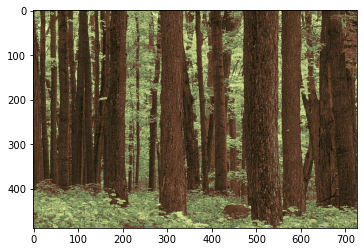

In [9]:
res = texture_synthesis(swatch_target,colored_swatches)
plt.imshow(cv2.cvtColor(res.astype("uint8"), cv2.COLOR_LAB2RGB))
plt.show()

In [29]:
cv2.imwrite('./output/swatch_output_1.jpg', cv2.cvtColor(res.astype("uint8"), cv2.COLOR_LAB2BGR))

True